In [5]:
from pymatgen.io.vasp import Xdatcar
from pymatgen.analysis.diffusion_analyzer import DiffusionAnalyzer
from vasppy.rdf import VanHoveAnalysis
import matplotlib.pyplot as plt
import numpy as np
import yaml
from pymatgen.util.coord import pbc_shortest_vectors

import sys
sys.path.insert(0, "../../scripts/")
from utils import flatten_list, get_structures, indices_by_species


In [3]:
with open('../md_runs.yaml', 'r') as f:
    md_runs = yaml.load(f)
print(md_runs)

{'Li6PS5I': {'0p': [1, 2, 3, 4, 5], '50p': [1, 2, 3, 4, 5], '100p': [1, 2, 3, 4]}, 'Li6PS5Cl': {'0p': [1, 2, 3, 4], '50p': [1, 2, 3, 4], '100p': [1, 2, 3, 4]}}


In [117]:
def st_correlation_function(dr_ij):
    dot_ij = np.einsum('ij,kj->ik', dr_ij, dr_ij)
    dot_ii = np.diag(dot_ij)
    return np.mean(dot_ij)/np.mean(dot_ii)

In [ ]:
from collections import Counter

data_dir = '../../data/'

d_steps_list = [10, 20, 30, 40, 50, 60, 100, 200, 300, 400, 500]
dr_data = {}
for system in md_runs:
    dr_data[system] = {}
    for disorder, runs in md_runs[system].items():
        print(f'{system} {disorder} inherent')
        dr_data[system][disorder] = {}
        for d_steps in d_steps_list:
            xdatcar_filenames = [ f'{data_dir}/{system}/{disorder}/run{i}/inherent_XDATCAR.gz' for i in runs ]
            xdatcars = ( Xdatcar( f ) for f in xdatcar_filenames )
            structures = flatten_list( [ x.structures for x in xdatcars ] )
            li_indices = indices_by_species( structures[0], 'Li' )
            lattice = structures[0].lattice

            self_dr = []
            for t, (struc_i, struc_j) in enumerate(zip( structures[:len(structures)-d_steps], 
                                                     structures[d_steps:]) ):
                i_frac_coords = struc_i.frac_coords[li_indices]
                j_frac_coords = struc_j.frac_coords[li_indices]
                dr_ij = pbc_shortest_vectors(lattice, i_frac_coords, j_frac_coords)
                dr_ii = np.einsum('iij->ij', dr_ij)
                self_dr.extend(dr_ii)
            dr_data[system][disorder][d_steps] = st_correlation_function(self_dr)
            print(f'{system} {disorder} {d_steps}: {dr_data[system][disorder][d_steps]}')
            


Li6PS5I 0p inherent


In [ ]:
def non_gaussian_parameter(dr):
    return 3.0 * np.mean(dr**4) / (5.0 * np.mean(dr**2)**2) - 1.0

/Users/bjm42/.pyenv/versions/3.7.0/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/bjm42/.pyenv/versions/3.7.0/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


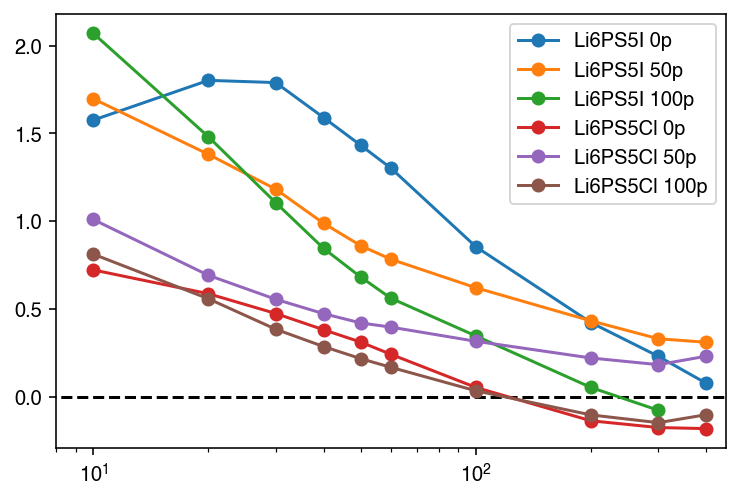

In [52]:
all_dt = [10, 20, 30, 40, 50, 60, 100, 200, 300, 400 ]
for system in ['Li6PS5I', 'Li6PS5Cl']:
    for disorder in ['0p', '50p', '100p']:
        alpha_2 = [ non_gaussian_parameter(np.array(dr_data[system][disorder][dt])) for dt in all_dt ]
        plt.semilogx(all_dt, alpha_2, 'o-', label=f'{system} {disorder}')
plt.legend()
plt.hlines(0,1,500, linestyles='--')
plt.xlim([8,450])
plt.show()

In [51]:
len(structures)

560

/Users/bjm42/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
/Users/bjm42/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


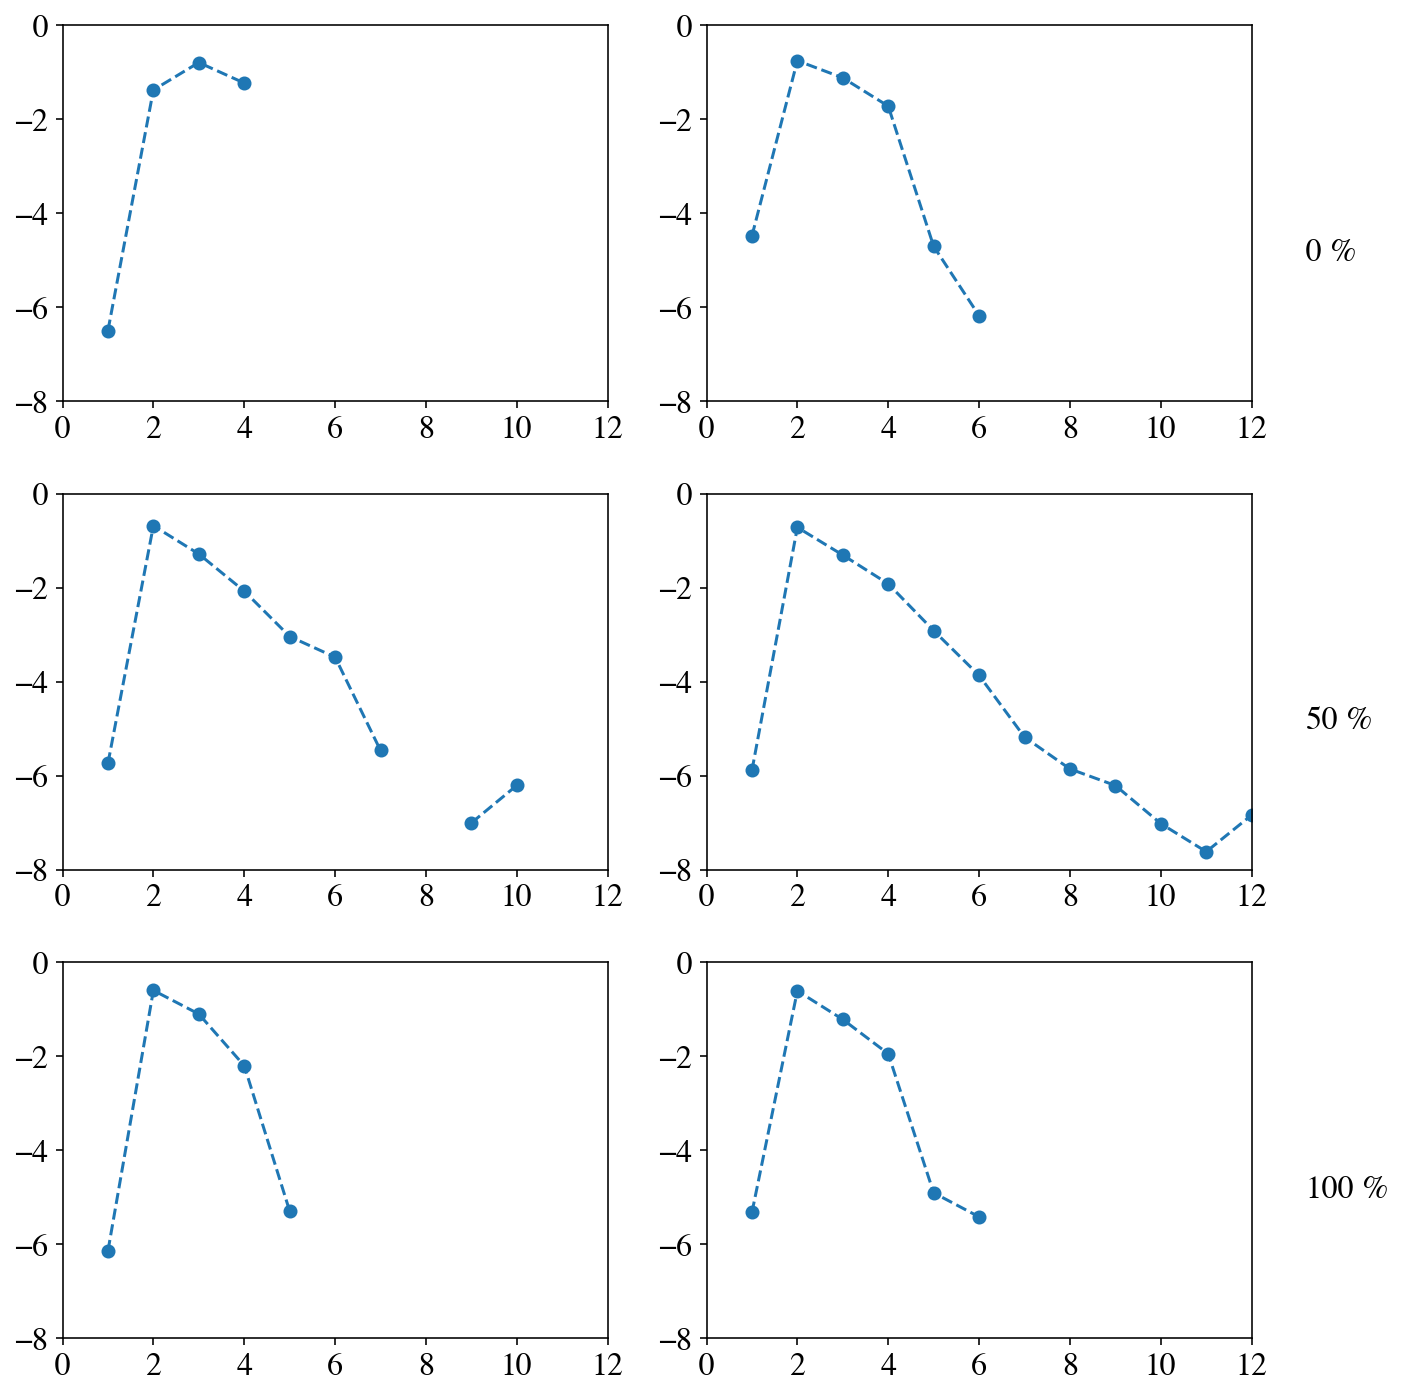

In [16]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Minion Pro']
rcParams['font.size'] = 16
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['mathtext.fontset'] = 'dejavuserif'

def plot_string_lengths(count, axes, sigma, label=None):
    for i in range(12):
        if i not in count.keys():
            count[i] = 0
    labels, values = zip(*sorted(count.items()))
    values = np.array(values)*np.arange(len(values))
    normalised_values = np.array([ v/sum(values) for v in values])
#     normalised_values *= np.arange(len(normalised_values))
    indexes = np.arange(len(labels))
    axes.plot(indexes, np.log(normalised_values), 'o--')
              
sigma = 0.1
fig, ax = plt.subplots(3,2,figsize=(10,10))

for i in [60]:
    label = r'$\Delta t =$' + str(i/10) + ' ps'
    plot_string_lengths(string_data['Li6PS5I']['0p'][i], axes=ax[0,0], sigma=sigma, label=label)
    plot_string_lengths(string_data['Li6PS5I']['50p'][i], axes=ax[1,0], sigma=sigma, label=label)
    plot_string_lengths(string_data['Li6PS5I']['100p'][i], axes=ax[2,0], sigma=sigma, label=label)
    plot_string_lengths(string_data['Li6PS5Cl']['0p'][i], axes=ax[0,1], sigma=sigma, label=label)
    plot_string_lengths(string_data['Li6PS5Cl']['50p'][i], axes=ax[1,1], sigma=sigma, label=label)
    plot_string_lengths(string_data['Li6PS5Cl']['100p'][i], axes=ax[2,1], sigma=sigma, label=label)

y_max = 3
for i in range(3):
    for j in range(2):
#         ax[i,j].set_ylim([0,y_max])
        ax[i,j].set_xlim([0,12])
        ax[i,j].set_ylim([-8,0])
#         ax[i,j].set_yticks([])
#         ax[i,j].legend(fancybox=False)
        
# for i in range(2):
#     for j in range(2):
#         ax[i,j].get_xaxis().set_visible(False)
        
# for i in range(3):
#         ax[i,1].get_yaxis().set_visible(False)

# xlabel = r'$r$ ($\mathrm{\AA}$)'
# ylabel = r'$4\pi G_\mathrm{d}(r)$'
for i in range(3):
    for j in range(2):
        ax[i,j].set_xticks(range(0,14,2))
# ax[0,0].set_title(r'Li$_6$PS$_5$I', pad=15)
# ax[0,1].set_title(r'Li$_6$PS$_5$Cl', pad=15)
# ax[2,0].set(xlabel=xlabel, ylabel=ylabel)
# ax[1,0].set(ylabel=ylabel)
# ax[0,0].set(ylabel=ylabel)
# ax[2,1].set(xlabel=xlabel)

ax[0,1].text(13.2,-5,'0 %')
ax[1,1].text(13.2,-5,'50 %')
ax[2,1].text(13.2,-5,'100 %')
    
fig.tight_layout()    
# fig.subplots_adjust(wspace=0, hspace=0)
fig.savefig('../../figures/distinct-VanHove.pdf', tight_layout=True)
fig.show()

In [ ]:
string_data['Li6PS5Cl']['100p'][50]

In [ ]:
labels, values = zip(*sorted(count.items()))
indexes = np.arange(len(labels))
width = 1

plt.plot(indexes, np.log(values), 'o--')
plt.xticks(indexes + width * 0.5, labels)
plt.show()

In [ ]:
c

In [ ]:
mask = np.ones(dr_ij.shape, dtype=bool)
np.fill_diagonal(mask, 0)

In [ ]:
np.invert(mask)

In [ ]:
a = [1,2,3,2,3]

In [ ]:
np.unique(a).shape[0]

In [6]:
np.diag(np.array([1,2,3,4]).reshape(2,2))

array([1, 4])

In [19]:
a = np.random.random(9).reshape(3,3)

In [20]:
st_correlation_function(a)

[[0.55457591 0.87116328 0.75836996]
 [0.47488824 0.10945035 0.90537196]
 [0.40679708 0.54330235 0.43408485]]
[0.55457591 0.87116328 0.75836996] [0.55457591 0.87116328 0.75836996] 1.6416048869907394
[0.55457591 0.87116328 0.75836996] [0.47488824 0.10945035 0.90537196] 1.045317598394496
[0.55457591 0.87116328 0.75836996] [0.40679708 0.54330235 0.43408485] 1.0281018274720042
[0.47488824 0.10945035 0.90537196] [0.55457591 0.87116328 0.75836996] 1.045317598394496
[0.47488824 0.10945035 0.90537196] [0.47488824 0.10945035 0.90537196] 1.0571966081700288
[0.47488824 0.10945035 0.90537196] [0.40679708 0.54330235 0.43408485] 0.6456560341464799
[0.40679708 0.54330235 0.43408485] [0.55457591 0.87116328 0.75836996] 1.0281018274720042
[0.40679708 0.54330235 0.43408485] [0.47488824 0.10945035 0.90537196] 0.6456560341464799
[0.40679708 0.54330235 0.43408485] [0.40679708 0.54330235 0.43408485] 0.6490909672419856


In [112]:
def st_correlation_function2(dr_ij):
    dot_ij = np.einsum('ij,kj->ik', dr_ij, dr_ij)
    dot_ii = np.diag(dot_ij)
#     print( np.mean(dot_ii), np.mean(dot_ij) )

In [113]:
%%timeit
st_correlation_function(a)

14.7 µs ± 322 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [114]:
%%timeit
st_correlation_function2(a)

5.81 µs ± 360 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [98]:
np.dot(a[0], a[1])

1.045317598394496

In [49]:
np.linalg.multi_dot()

LinAlgError: 1-dimensional array given. Array must be two-dimensional

In [47]:
a

array([[0.55457591, 0.87116328, 0.75836996],
       [0.47488824, 0.10945035, 0.90537196],
       [0.40679708, 0.54330235, 0.43408485]])

In [67]:
a.T.dot(a)

array([[0.69855714, 0.75611666, 1.02710865],
       [0.75611666, 1.06608228, 0.99559666],
       [1.02710865, 0.99559666, 1.58325304]])